In [15]:
import numpy as np
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as tvutils
import torch.utils.data as datautils
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# use gpu if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [16]:
# return iterable over dataset that will load minibatches (size = 128) for training
# preprocessing: images are resized to 64x64, each channel is normalized with mean = 0.5, s = 0.5
# Normalizing channel is changing the range of pixel intensity values.
# Num_workers denotes the number of processes that generate batches in parallel.
def get_loader(datapath):
    dataset = datasets.ImageFolder(root=datapath,transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
    loader = datautils.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)
    return loader

In [17]:
# view training data sample images as 8x8 grid
# np.transpose returns view of the array unchanged
# plt axis plots legends and whitspaces
def view_images(loader):
    sample = next(iter(dataloader))
    plt.figure(figsize=(12,12))
    plt.axis('off')
    plt.title('Dataset Sample Images')
    plt.imshow(np.transpose(tvutils.make_grid(sample[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

In [18]:
# super() builtin returns a temporary object of the superclassthat allows us to access methods of the base class
class Generator(nn.Module):
    def __init__(self, z_size=100, num_channels=3, gfm_size=64):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            
            # input layer (latent vector z taken as input)
            nn.ConvTranspose2d(z_size, gfm_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(gfm_size * 8),
            nn.ReLU(True),
            
            # state size: (gfm_size * 8) x 4 x 4
            nn.ConvTranspose2d(gfm_size * 8, gfm_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gfm_size * 4),
            nn.ReLU(True),
            
            # state size: (gfm_size * 4) x 8 x 8
            nn.ConvTranspose2d( gfm_size * 4, gfm_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gfm_size * 2),
            nn.ReLU(True),
            
            # state size: (gfm_size * 2) x 16 x 16
            nn.ConvTranspose2d( gfm_size * 2, gfm_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gfm_size),
            nn.ReLU(True),
            
            # state size: (gfm_size) x 32 x 32
            nn.ConvTranspose2d(gfm_size, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # output: num_channels x 64 x 64
        )
        
    def forward(self, input):
        return self.main(input)

In [19]:
class Discriminator(nn.Module):
    def __init__(self, num_channels=3, dfm_size=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            
            # input: num_channels x 64 x 64 
            nn.Conv2d(num_channels, dfm_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size: dfm_size x 32 x 32
            nn.Conv2d(dfm_size, dfm_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dfm_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size: (dfm_size * 2) x 16 x 16
            nn.Conv2d(dfm_size * 2, dfm_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dfm_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size: (dfm_size * 4) x 8 x 8
            nn.Conv2d(dfm_size * 4, dfm_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dfm_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size: (dfm_size * 8) x 4 x 4
            nn.Conv2d(dfm_size * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        # view(-1) flattens the output from 2D to 1D 
        return self.main(input).view(-1)

In [20]:
# initialize all model weights
def init_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

## IMPORT THE DATASET

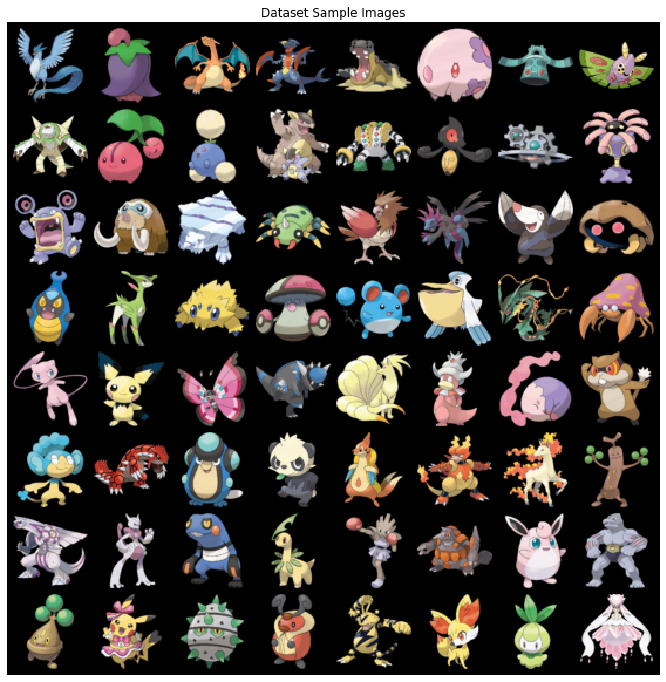

In [21]:
path ="C:\\Users\\Acer\\Downloads\\pokemon-images-dataset"
dataloader = get_loader(path)
view_images(dataloader)

In [22]:
num_epochs = 150
z_size = 100
real_label = 1
fake_label = 0

# creating generator and discriminator networks
gen_net = Generator().to(device)
disc_net = Discriminator().to(device)

# init_weights is applied to self and every submodule recursively
gen_net.apply(init_weights)
disc_net.apply(init_weights)

print(gen_net, disc_net)

# create criterion to measure error (binary cross entropy between target and output)
bce_loss = nn.BCELoss()

# create Adam SGD optimizers with learning rate 0.0002 and beta1 = 0.5
gen_opt = optim.Adam(gen_net.parameters(), lr=0.0002, betas=(0.5, 0.999))
disc_opt = optim.Adam(disc_net.parameters(), lr=0.0002, betas=(0.5, 0.999))

# noise used for visualizing generator's learning curve 
test_noise = torch.randn(64, z_size, 1, 1, device=device)

image_lst = []
gen_losses = []
disc_losses = []
num_iter = 2

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
) 

## TRAINING TIME

In [23]:
from tqdm import tqdm
for epoch in range(num_epochs):
    for idx,data in enumerate(dataloader):
        
        # DISCRIMINATOR UPDATE

        # set gradients of all model parameters to zero
        disc_net.zero_grad()
        
        # get batch of all real images
        real_batch = data[0].to(device)
        batch_size = real_batch.size(0)
        labels = torch.full((batch_size,), real_label, device=device)
        
        # forward pass real batch through discriminator
        output = disc_net(real_batch)
        disc_loss_real = bce_loss(output, labels)
        
        # calculate gradients for discriminator in backward pass
        disc_loss_real.backward()
        Dx_value = output.mean().item()
        
        # get batch of all fake images
        latent_z = torch.randn(batch_size, z_size, 1, 1, device=device)
        fake_batch = gen_net(latent_z)
        labels.fill_(fake_label)
        
        # classify fake images using discriminator
        output = disc_net(fake_batch.detach())
        disc_loss_fake = bce_loss(output, labels)
        
        # calculate gradients for discriminator in backward pass
        disc_loss_fake.backward()
        DGz_value_1 = output.mean().item()
        
        # add gradients from both batches, save total loss
        disc_loss = disc_loss_real + disc_loss_fake
        disc_losses.append(disc_loss.item())
        
        # update discriminator
        #step() is to update
        disc_opt.step()
        
        # GENERATOR UPDATE
        
        # set gradients of all model parameters to zero
        gen_net.zero_grad()
        
        # fake labels are "real" in terms of generator cost
        labels.fill_(real_label)
        
        # after updating discriminator, perform another forward pass of fake batch
        output = disc_net(fake_batch)
        
        # calculate and save generator loss on discriminator's new output 
        gen_loss = bce_loss(output, labels)
        gen_losses.append(gen_loss.item())
        
        # calculate gradients for generator in backward pass
        gen_loss.backward()
        DGz_value_2 = output.mean().item()
        
        # update generator
        gen_opt.step()
        
        # print update every 100th batch
        if idx % 100 == 0:
            print('Epoch: %d/%d Idx: %d/%d\nLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                % (epoch, num_epochs, idx, len(dataloader),
                disc_loss.item(), gen_loss.item(), Dx_value, DGz_value_1, DGz_value_2))
        
        # periodically test and save generator performance on test_noise
        # do not calculate gradients
        if (num_iter % 500 == 0) or ((epoch == num_epochs-1) and (idx == len(dataloader)-1)):           
            with torch.no_grad():
                fake_image = gen_net(test_noise).detach().cpu()
            image_lst.append(tvutils.make_grid(fake_image, padding=2, normalize=True))
        
        num_iter += 2

Epoch: 0/150 Idx: 0/7
Loss_D: 1.1974	Loss_G: 4.4452	D(x): 0.5769	D(G(z)): 0.3859 / 0.0171
Epoch: 1/150 Idx: 0/7
Loss_D: 0.3528	Loss_G: 8.4297	D(x): 0.9509	D(G(z)): 0.2174 / 0.0003
Epoch: 2/150 Idx: 0/7
Loss_D: 2.8562	Loss_G: 17.6500	D(x): 0.9904	D(G(z)): 0.9097 / 0.0000
Epoch: 3/150 Idx: 0/7
Loss_D: 0.8398	Loss_G: 8.6308	D(x): 0.5726	D(G(z)): 0.0004 / 0.0002
Epoch: 4/150 Idx: 0/7
Loss_D: 0.0427	Loss_G: 11.5475	D(x): 0.9634	D(G(z)): 0.0000 / 0.0000
Epoch: 5/150 Idx: 0/7
Loss_D: 1.7859	Loss_G: 17.3237	D(x): 0.9863	D(G(z)): 0.7607 / 0.0000
Epoch: 6/150 Idx: 0/7
Loss_D: 0.5553	Loss_G: 17.0279	D(x): 0.7001	D(G(z)): 0.0000 / 0.0000
Epoch: 7/150 Idx: 0/7
Loss_D: 5.2031	Loss_G: 13.3742	D(x): 0.0304	D(G(z)): 0.0000 / 0.0000
Epoch: 8/150 Idx: 0/7
Loss_D: 0.8556	Loss_G: 4.9077	D(x): 0.8696	D(G(z)): 0.3786 / 0.0177
Epoch: 9/150 Idx: 0/7
Loss_D: 0.6192	Loss_G: 5.1219	D(x): 0.8416	D(G(z)): 0.3103 / 0.0088
Epoch: 10/150 Idx: 0/7
Loss_D: 0.8736	Loss_G: 2.1366	D(x): 0.5460	D(G(z)): 0.1097 / 0.1547
Epoc

Loss_D: 0.5888	Loss_G: 5.3281	D(x): 0.9695	D(G(z)): 0.3974 / 0.0086
Epoch: 91/150 Idx: 0/7
Loss_D: 0.3407	Loss_G: 3.2460	D(x): 0.8347	D(G(z)): 0.1312 / 0.0564
Epoch: 92/150 Idx: 0/7
Loss_D: 0.2776	Loss_G: 3.2186	D(x): 0.8457	D(G(z)): 0.0952 / 0.0553
Epoch: 93/150 Idx: 0/7
Loss_D: 1.4217	Loss_G: 6.5465	D(x): 0.9908	D(G(z)): 0.6667 / 0.0035
Epoch: 94/150 Idx: 0/7
Loss_D: 1.1051	Loss_G: 4.4881	D(x): 0.9878	D(G(z)): 0.6050 / 0.0222
Epoch: 95/150 Idx: 0/7
Loss_D: 0.7738	Loss_G: 2.0468	D(x): 0.5424	D(G(z)): 0.0715 / 0.1757
Epoch: 96/150 Idx: 0/7
Loss_D: 1.4272	Loss_G: 2.0082	D(x): 0.2911	D(G(z)): 0.0086 / 0.2000
Epoch: 97/150 Idx: 0/7
Loss_D: 0.8863	Loss_G: 5.6146	D(x): 0.9709	D(G(z)): 0.5174 / 0.0059
Epoch: 98/150 Idx: 0/7
Loss_D: 0.3565	Loss_G: 3.1973	D(x): 0.8679	D(G(z)): 0.1813 / 0.0533
Epoch: 99/150 Idx: 0/7
Loss_D: 0.4138	Loss_G: 3.7489	D(x): 0.8547	D(G(z)): 0.2067 / 0.0325
Epoch: 100/150 Idx: 0/7
Loss_D: 0.3524	Loss_G: 3.8706	D(x): 0.9393	D(G(z)): 0.2315 / 0.0290
Epoch: 101/150 Idx: 0

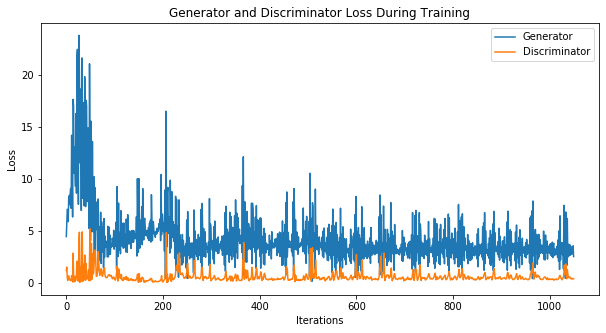

In [24]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_losses,label="Generator")
plt.plot(disc_losses,label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

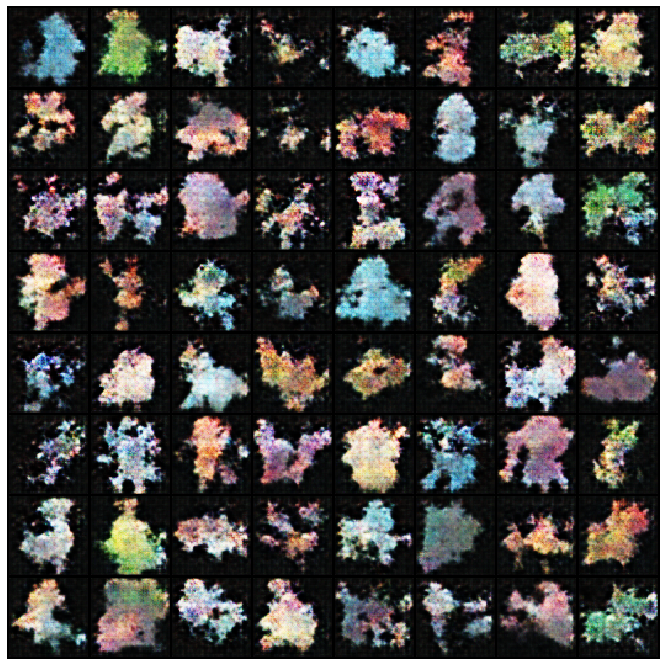

In [25]:
fig = plt.figure(figsize=(12,12))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)))] for i in image_lst]